<a href="https://colab.research.google.com/github/18521099/DAPHUONGTIEN/blob/master/dog_breed_indentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import join
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications import xception
from keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from google.colab import drive
drive.mount('/mydrive', True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /mydrive


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gaborfodor/keras-pretrained-models

 99% 937M/943M [00:11<00:00, 55.6MB/s]
100% 943M/943M [00:11<00:00, 82.5MB/s]


In [ ]:
path = '/mydrive/My Drive/Dog breed/'
input_size = 224
num_classes = 16
SEED = 1987
labels = pd.read_csv(join(path, 'labels.csv'))

In [ ]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED) 
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

READ IMAGE FUNCTION

In [ ]:
def read_img(img_id, train_or_test, size):
    #Read and Resize image
    img = image.load_img(join(path, train_or_test, '%s.jpg' % img_id), target_size=size)
    #Image as numpy array
    img = image.img_to_array(img)
    return img

VGG16


In [ ]:
INPUT_SIZE = 224
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:11, 152.34it/s]

Train Images shape: (1777, 224, 224, 3) size: 267,488,256


BEFORE PREPROCESS

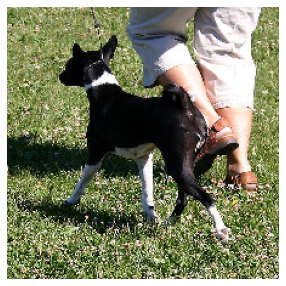

In [ ]:
test_img = list(labels['id'])[0]
test_img = read_img(test_img, 'train', (INPUT_SIZE, INPUT_SIZE))
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(test_img/ 255. )
ax.axis('off')
plt.show()

AFTER PREPROCESS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


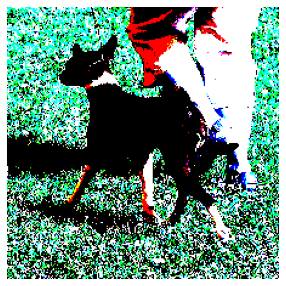

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(x_train[0])
ax.axis('off')
plt.show()  

FEATURE EXTRACTOR

In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg = VGG16(weights='imagenet', include_top=False, pooling='avg')
train_vgg = vgg.predict(Xtr, batch_size=32, verbose=1)
valid_vgg = vgg.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg.shape, train_vgg.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg.shape, valid_vgg.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
368/368 [==============================] - 166s 451ms/step
VGG train bottleneck features shape: (1409, 512) size: 721,408
VGG valid bottleneck features shape: (368, 512) size: 188,416


LOGISTIC REGRESSION VGG16


In [ ]:
logreg = LogisticRegression(multi_class='multinomial', random_state=SEED, max_iter=2000)
logreg.fit(train_vgg, (ytr * range(num_classes)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg)
valid_preds = logreg.predict(valid_vgg)
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(num_classes)).sum(axis=1), valid_preds)))

Validation VGG LogLoss 0.3545031907265375
Validation VGG Accuracy 0.9239130434782609


In [ ]:
import pickle
filename = '/mydrive/My Drive/logregVGG16.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [ ]:
import pickle
logregVGG16 = pickle.load(open('/mydrive/My Drive/logregVGG16.sav', 'rb'))

MISCLASSIFICATION

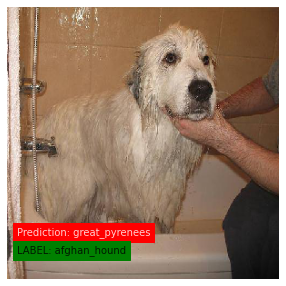

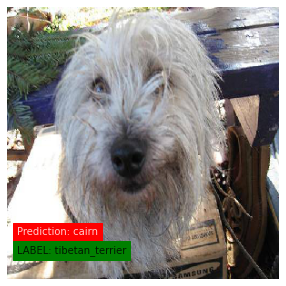

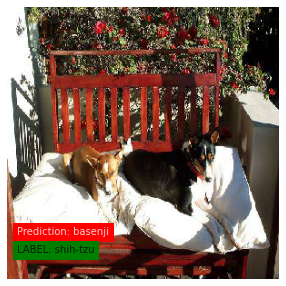

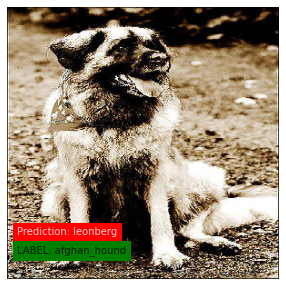

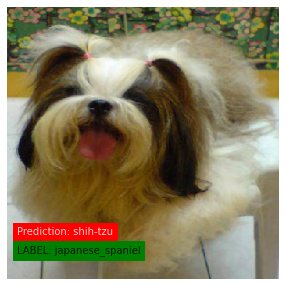

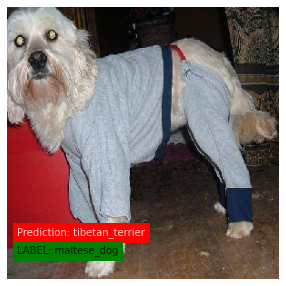

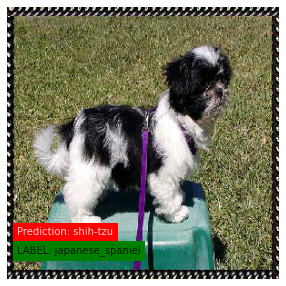

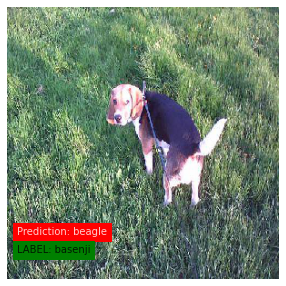

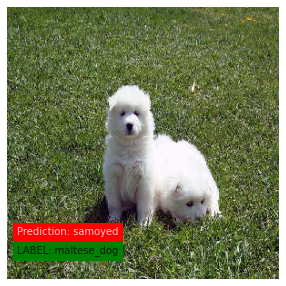

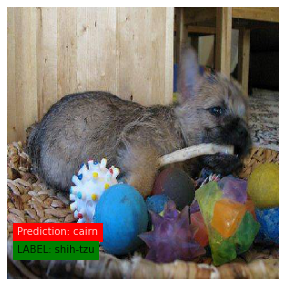

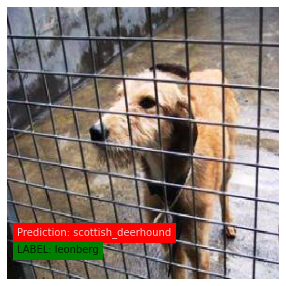

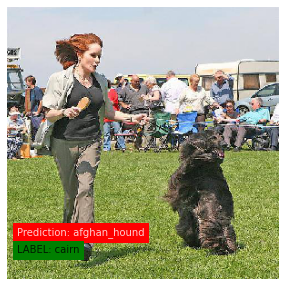

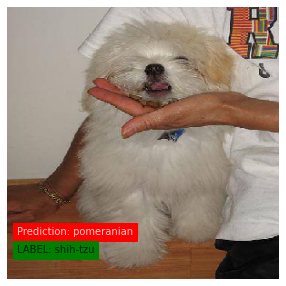

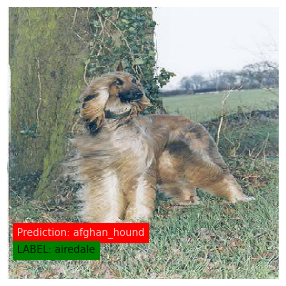

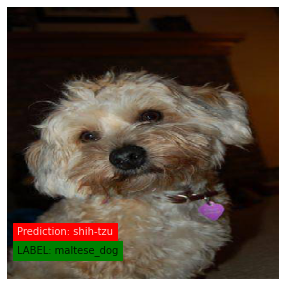

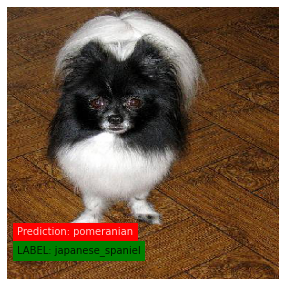

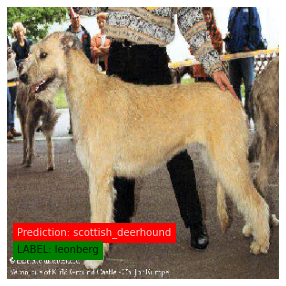

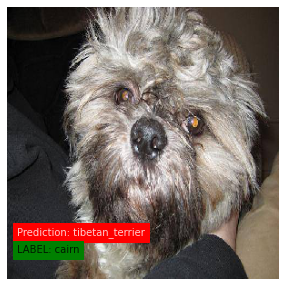

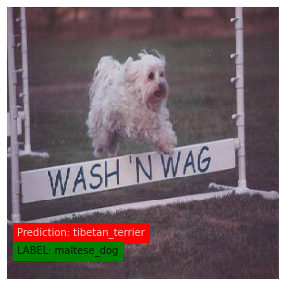

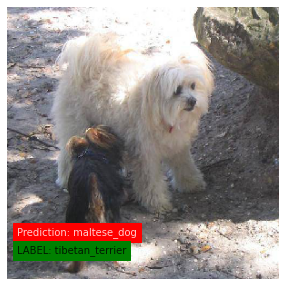

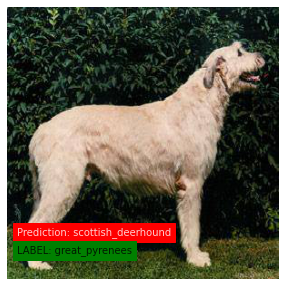

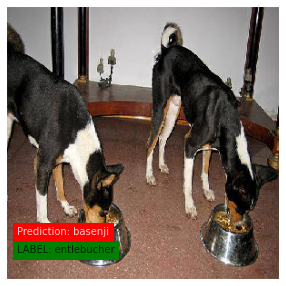

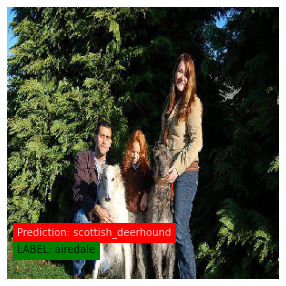

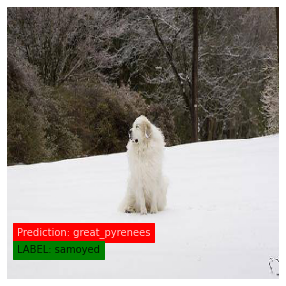

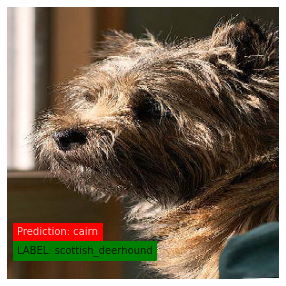

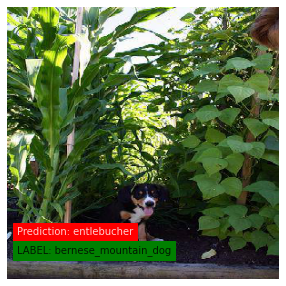

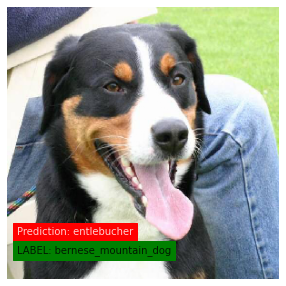

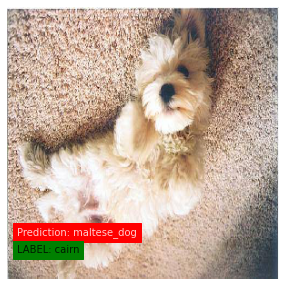

In [ ]:
valid_breeds = (yv * range(num_classes)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                                [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                                [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()   

XCEPTION

In [ ]:
INPUT_SIZE = 299
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:11, 161.51it/s]

Train Images shape: (1777, 299, 299, 3) size: 476,596,731


BEFORE PREPROCESS

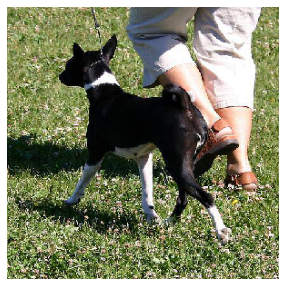

In [ ]:
test_img = list(labels['id'])[0]
test_img = read_img(test_img, 'train', (INPUT_SIZE, INPUT_SIZE))
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(test_img/ 255. )
ax.axis('off')
plt.show()

AFTER PREPROCESS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


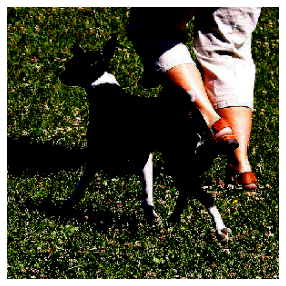

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(x_train[0])
ax.axis('off')
plt.show()  

FEATURE EXTRACTOR

In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - 166s 450ms/step
Xception train bottleneck features shape: (1409, 2048) size: 2,885,632
Xception valid bottleneck features shape: (368, 2048) size: 753,664


LOGISTIC REGRESSION XCEPTION

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', random_state=SEED, max_iter=200)
logreg.fit(train_x_bf, (ytr * range(num_classes)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(num_classes)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.06822600089010726
Validation Xception Accuracy 0.9809782608695652


MISCLASSIFICATION CLASSES

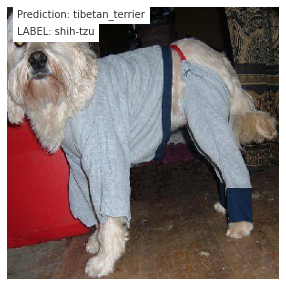

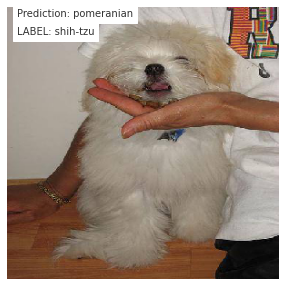

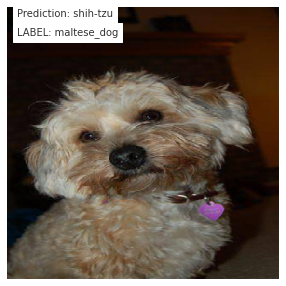

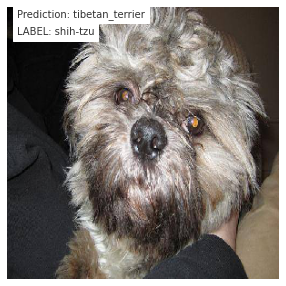

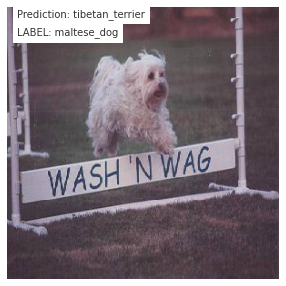

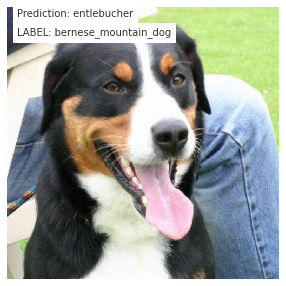

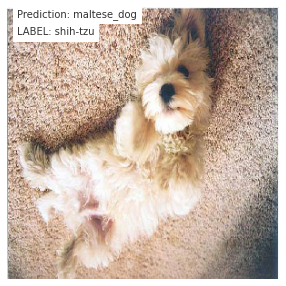

In [ ]:
valid_breeds = (yv * range(num_classes)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                                [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                                [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 10, 'Prediction: %s' % pred, color='black', backgroundcolor='w', alpha=0.8)
    ax.text(10, 30, 'LABEL: %s' % breed, color='black', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
    plt.show()   

In [ ]:
def predictBreedXception(path):
  testImg = image.load_img(path, target_size=(299,299))
  testImg = image.img_to_array(testImg)
  fig, ax = plt.subplots(figsize=(5,5))
  ax.imshow(testImg/ 255. )
  ax.axis('off')
  plt.show()
  testImg = xception.preprocess_input(np.expand_dims(testImg.copy(), axis=0))
  vgg_test = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
  testImg = vgg_test.predict(testImg, batch_size=32, verbose=1)
  test_breed = logregXception.predict(testImg)
  print('prediction: ', selected_breed_list[int(test_breed[0])])
  
def predictBreedVGG16(path):
  testImg = image.load_img(path, target_size=(224,224))
  testImg = image.img_to_array(testImg)
  fig, ax = plt.subplots(figsize=(5,5))
  ax.imshow(testImg/ 255. )
  ax.axis('off')
  plt.show()
  testImg = preprocess_input(np.expand_dims(testImg.copy(), axis=0))
  vgg_test = VGG16(weights='imagenet', include_top=False, pooling='avg')
  testImg = vgg_test.predict(testImg, batch_size=32, verbose=1)
  test_breed = logregVGG16.predict(testImg)
  print('prediction: ', selected_breed_list[int(test_breed[0])])

import pickle
logregXception = pickle.load(open('/mydrive/My Drive/logregXception.sav', 'rb'))
logregVGG16 = pickle.load(open('/mydrive/My Drive/logregVGG16.sav', 'rb'))

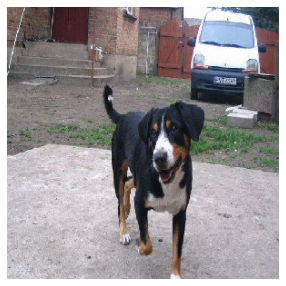

1/1 [==============================] - 1s 933ms/step
prediction:  entlebucher


In [ ]:
path_test = '/mydrive/My Drive/Dog breed/test/0a053ff8908375e9579ead9f3965e0ce.jpg'
predictBreedXception(path_test)

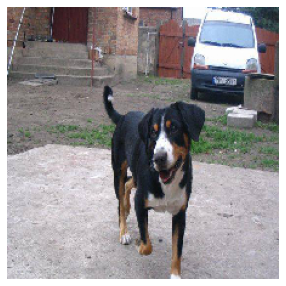

1/1 [==============================] - 1s 500ms/step
prediction:  entlebucher


In [ ]:
predictBreedVGG16(path_test)